# Import libraries

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb
# !pip install optuna
# import optuna  
# from optuna.integration import LightGBMPruningCallback
!pip install verstack
from verstack import LGBMTuner
from sklearn.ensemble import RandomForestRegressor
import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

from sklearn.model_selection import TimeSeriesSplit, cross_val_score




# Import the data

In [40]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

# Examine the data

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


No missing values

In [42]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Starts from 2018-03-01 00:00:00

In [43]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


End at 2018-08-31 23:00:00

# Analyse the data

Let's break the orders into one contribute to the trend, seasonality and general noise 

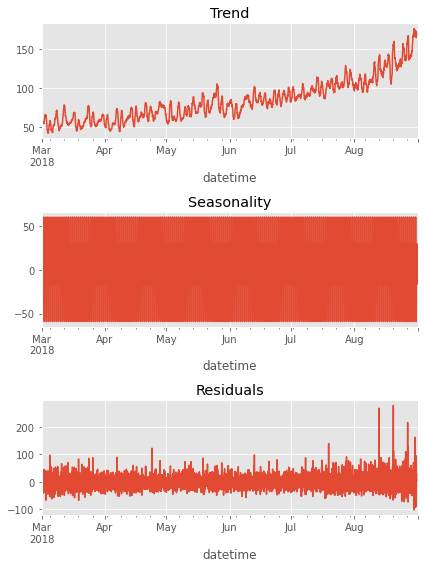

In [44]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

There is a obvious trend of increasing number of order in this period. The residuals stays almost the same. With Seasonality we have problem with this time sample. I guess that by sampeling shorter period we might learn more. I will take half month  

<AxesSubplot:xlabel='datetime'>

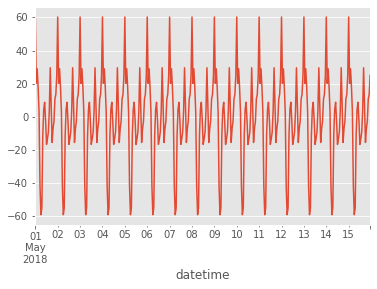

In [45]:
new_data = decomposed.seasonal['2018-05-01':'2018-05-15']
new_data.plot()

Now it looks more obvious. I will try 3 days to make it clearer

In [46]:
new_data = decomposed.seasonal['2018-05-01':'2018-05-03']
px.line(new_data).show()

We can see the highest peak of orders is at midnight. Second high peak is afternoon by 4 PM. Then at 10 AM . And the lowest time is 6 AM

Now let's check the rolling mean and std of orders during this time

<AxesSubplot:xlabel='datetime'>

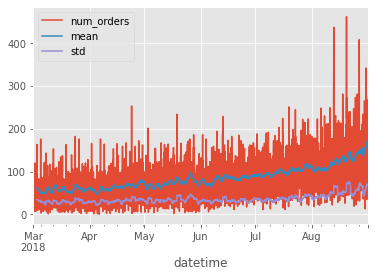

In [47]:
new_data = data.copy(deep=True)
new_data['mean'] = data['num_orders'].rolling(50).mean()
new_data['std'] = data['num_orders'].rolling(50).std()
new_data.plot() 

By the end of this period in august we can see an increase in orders amount and also higher variance

# Feature engineering

In [48]:
# Creating features
def make_features(df, max_lag, rolling_mean_size_hour, rolling_mean_size_day):
    column_heading = df.columns[0] 
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df[column_heading].shift(lag)

    df['rolling_mean_hour'] = df[column_heading].shift().rolling(rolling_mean_size_hour).mean()
    df['rolling_mean_day'] = df[column_heading].shift().rolling(rolling_mean_size_day).mean()

make_features(data, 5, 2, 24)
data

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean_hour,rolling_mean_day
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,104.5,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,78.0,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,68.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,212.0,164.875000
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,171.5,167.541667
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,145.0,168.041667


In [49]:
# remove the nan cause by lag and rolling mean in the dataset beggining
data.dropna(inplace=True)

# Prepare data for model selection

In [50]:
# Split train and test 
X = data.drop(['num_orders'], axis=1)
y = data[['num_orders']]

X_train_eval, X_test, y_train_eval, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_train_eval, y_train_eval, shuffle=False, test_size=0.2)


X_train.shape, X_eval.shape, y_train.shape, y_eval.shape, X_test.shape, y_test.shape


((3161, 11), (791, 11), (3161, 1), (791, 1), (440, 11), (440, 1))

# Model selection

In [51]:
# create df to store results
results_df = pd.DataFrame(columns=['model_type', 'RMSE', 'model_call_name'])

In [52]:
def append_to_score_df(model_name:str, RMSE:float, model_call_name:str):
    row_val = [model_name, round(RMSE, 2), model_call_name]
    results_df.loc[len(results_df)] = row_val
    print(results_df)

Create a function for cross validation

In [53]:
def cross_val_score_rmse_for_model(model, X_for_cross_train, y_for_cross_train) -> float:
    tscv = TimeSeriesSplit()
    rmse = np.abs(np.mean(cross_val_score(model, X_train_eval, y_train_eval, cv=tscv, scoring='neg_root_mean_squared_error')))
    return rmse

## Linear Regression

In [54]:
lr = LinearRegression() 
rmse = cross_val_score_rmse_for_model(
    model=lr, X_for_cross_train=X_train_eval, y_for_cross_train=y_train_eval
)
lr.fit(X_train_eval, y_train_eval)
append_to_score_df(model_name='linear regression', RMSE=rmse, model_call_name='lr')

          model_type   RMSE model_call_name
0  linear regression  31.52              lr


## Random Forest Regressor

In [55]:
rfr = RandomForestRegressor(random_state=12345) 
rmse = cross_val_score_rmse_for_model(
    model=rfr, X_for_cross_train=X_train_eval, y_for_cross_train=y_train_eval
)
rfr.fit(X_train_eval, y_train_eval)
append_to_score_df(model_name='Random Forest regression', RMSE=rmse, model_call_name='rfr')

                 model_type   RMSE model_call_name
0         linear regression  31.52              lr
1  Random Forest regression  25.29             rfr


## Random Forest Regressor with parameter tuning

In [56]:
# create dictionary for the parameters to be tunned

# Maximum number of levels in tree
max_depth = np.arange(3,12)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}


In [57]:
def rmse_score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5

In [58]:
scorer = make_scorer(rmse_score, greater_is_better=False)

In [59]:
rfr_random_tunner = RandomForestRegressor(random_state=12345)
tscv = TimeSeriesSplit()
clf = RandomizedSearchCV(
    estimator=rfr_random_tunner,
    param_distributions=random_grid,
    n_iter=5, cv=tscv, random_state=12345,
    scoring=scorer
)

In [60]:
%%time

clf.fit(X_train_eval, y_train_eval)

Wall time: 20.5 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=12345,
                   scoring=make_scorer(rmse_score, greater_is_better=False))

In [61]:
append_to_score_df(model_name='Random Forest regression with tuning',
                   RMSE=np.abs(clf.best_score_), model_call_name='clf')

                             model_type   RMSE model_call_name
0                     linear regression  31.52              lr
1              Random Forest regression  25.29             rfr
2  Random Forest regression with tuning  25.43             clf


## light GBM 

In [62]:
lgbmr = lgb.LGBMRegressor(random_state=12345)
rmse = cross_val_score_rmse_for_model(
    model=lgbmr, X_for_cross_train=X_train_eval, y_for_cross_train=y_train_eval
)


lgbmr.fit(X_train_eval, y_train_eval)
append_to_score_df(model_name='LGBM Regressor', RMSE=rmse, model_call_name='lgbmr')

                             model_type   RMSE model_call_name
0                     linear regression  31.52              lr
1              Random Forest regression  25.29             rfr
2  Random Forest regression with tuning  25.43             clf
3                        LGBM Regressor  25.50           lgbmr


## light GBM with tuning


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 23.929715381372397
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 22.6195847131176
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 20.869321877120537
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 20.719907969563074
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 24.013723880769504
 ................................................

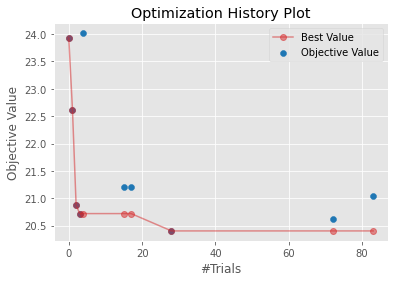

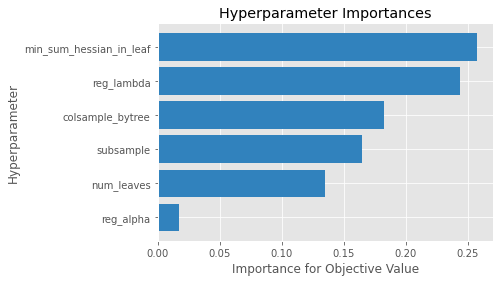

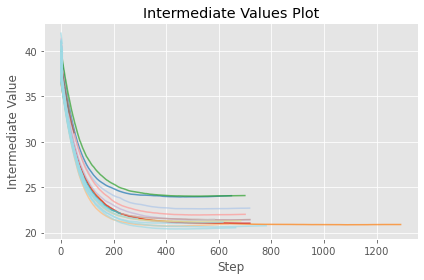

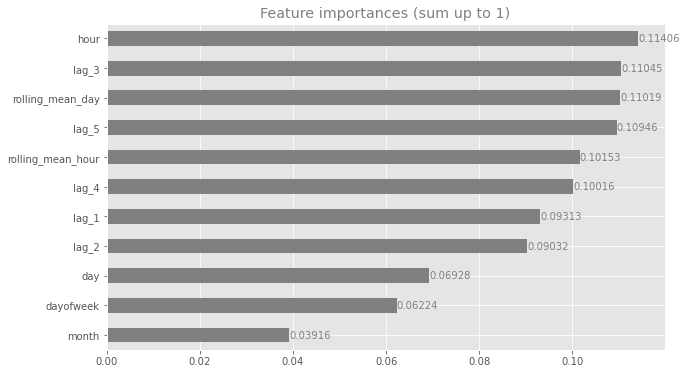


     . Optuna hyperparameters optimization finished
     .. Best trial number:28    |     rmse:           20.403479409113807
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  461   |     rmse:           21.216020653069616

Time elapsed for fit execution: 32.01951 seconds
Wall time: 32 s


In [63]:
%%time

tuner = LGBMTuner(metric = 'rmse', seed=12345) # <- the only required argument
tuner.fit(X_train_eval, y_train_eval['num_orders'])

Here we can see the features that have the highest effect on the score.

In [64]:
rmse = min(tuner.eval_results.values())
append_to_score_df(model_name='LGBM Regressor with hyperparameters tunner',
                   RMSE=rmse, model_call_name='tuner')

                                   model_type   RMSE model_call_name
0                           linear regression  31.52              lr
1                    Random Forest regression  25.29             rfr
2        Random Forest regression with tuning  25.43             clf
3                              LGBM Regressor  25.50           lgbmr
4  LGBM Regressor with hyperparameters tunner  20.40           tuner


# Test selected model

In [65]:
results_df.sort_values(by='RMSE', inplace=True)
results_df

,model_type,RMSE,model_call_name
4,LGBM Regressor with hyperparameters tunner,20.40,tuner
1,Random Forest regression,25.29,rfr
2,Random Forest regression with tuning,25.43,clf
3,LGBM Regressor,25.50,lgbmr
0,linear regression,31.52,lr


We will select the model with the best RMSE score and use it to predict on the test set

In [66]:
name_of_model = results_df.iloc[0]['model_call_name']
# retrieve the best model
model = locals()[name_of_model]

Calculate the RMSE on the model

In [67]:
# calculate rmse
score_for_best_model = rmse_score(y_test, model.predict(X_test))
print(f"{results_df.iloc[0]['model_type']} RMSE on the test set: {score_for_best_model:.2f}")


LGBM Regressor with hyperparameters tunner RMSE on the test set: 44.49


# Conclusion

In [68]:
if score_for_best_model < 48:
    print(f'We managed to produce model that give RMSE lower then 48 on the test set!\n\
The RMSE score we got is lower in {(48-score_for_best_model):.2} then the goal of the project')
else:
    print(f"The project goal didn't achived\n\
The RMSE score we got is higher in {(score_for_best_model-48):.2} then the goal of the project")

We managed to produce model that give RMSE lower then 48 on the test set!
The RMSE score we got is lower in 3.5 then the goal of the project


We see that for the lgbm the tunning we did make massive improvement while for the random forest it didn't. All models achieved better results than the linear regression. This is a good sign for the linear regression model serves as a benchmark for the most naive prediction  